In [1]:
import itertools
import matplotlib.pyplot as plot
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sklearn import cluster
from sklearn import model_selection
from sklearn import neural_network
from sklearn import preprocessing

/home/user/opt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.options.display.width = 200
pd.options.display.max_columns = 50

In [3]:
train = pd.read_csv('../data/in/train.csv', delimiter=';')
test = pd.read_csv('../data/in/test.csv', delimiter=';')
#y = train.cardio
#train.drop('cardio', axis=1, inplace=True)
test['cardio'] = -1

In [4]:
xgb_params = dict(
    learning_rate = 0.02,
    #objective = 'binary:logistic',
    #eval_metric = 'logloss',
    silent = 1,
    seed = 1
    )
def f(col, mark = 1, cut_max = 1.5):
    #print(np.sum(train[col] != train[col]))
    x = np.abs(train[col].values)
    dtrain = xgb.DMatrix(train.drop(['cardio', 'id', col], axis=1).values, label=x)
    cv = xgb.cv(xgb_params, dtrain, num_boost_round=10000, early_stopping_rounds=20)
    print('len(cv) =', len(cv))
    bst = xgb.train(xgb_params, dtrain, num_boost_round=len(cv))
    print('trained')
    x2 = bst.predict(dtrain)
    e = np.abs(x - x2)
    k = np.where(np.abs(x) > 1e-5, e / x, e)
    k = np.where(k < cut_max, k, cut_max)
    plot.figure(figsize=(24, 8))
    plot.hist(k, bins=200)
    plot.vlines(x=mark, ymin=0, ymax=12000)
    plot.show()
    print(np.sum(k > mark), len(k), np.sum(k > mark) / len(k))
    print('done.')

len(cv) = 95
trained


/home/user/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in true_divide


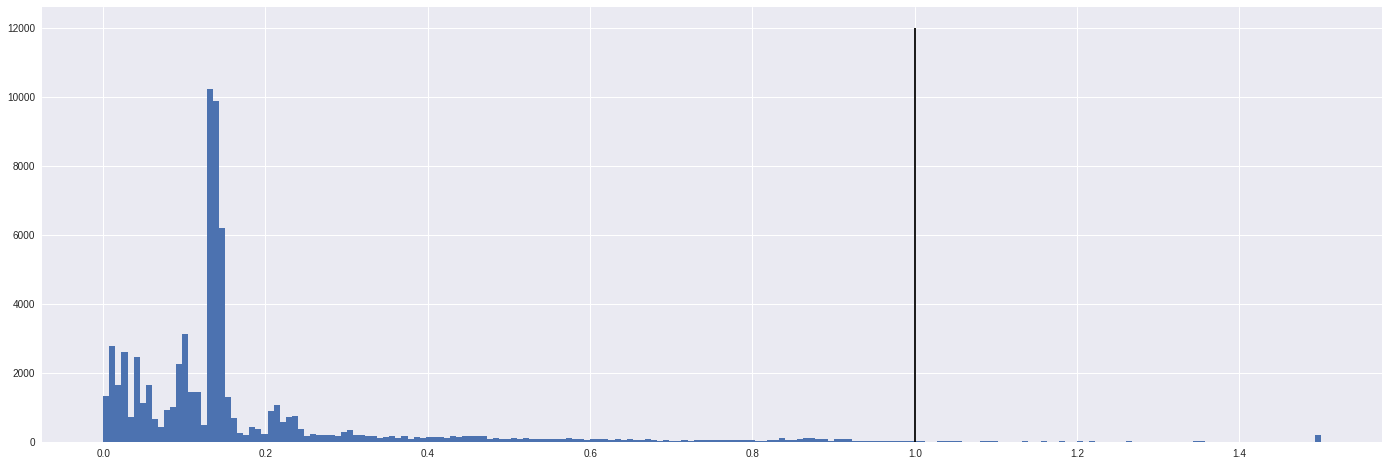

629 70000 0.00898571428571
done.


In [5]:
f('ap_lo')

len(cv) = 53
trained


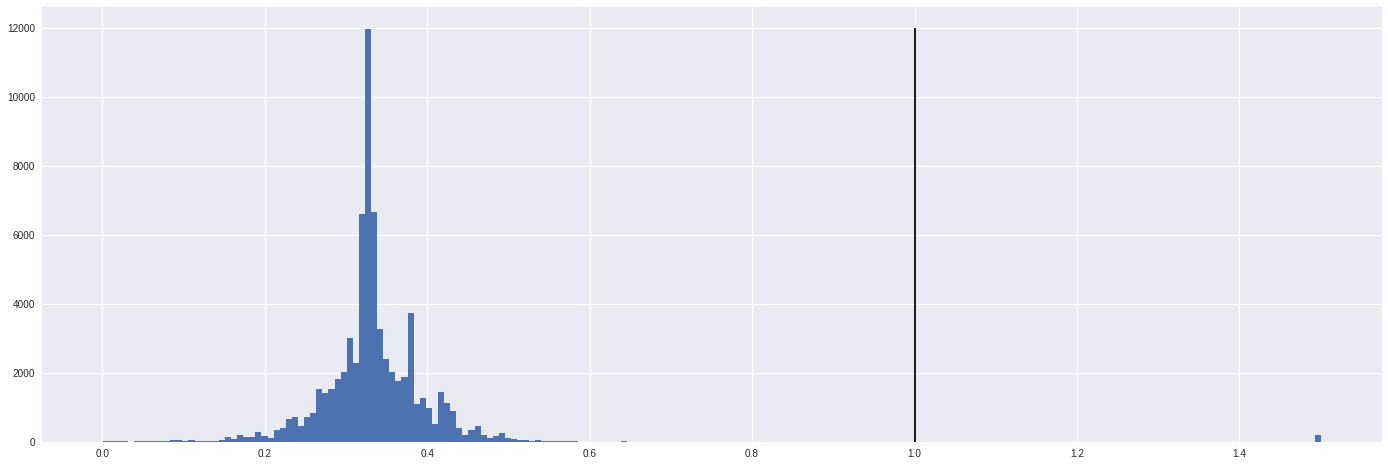

194 70000 0.00277142857143
done.


In [6]:
f('ap_hi')

len(cv) = 335
trained


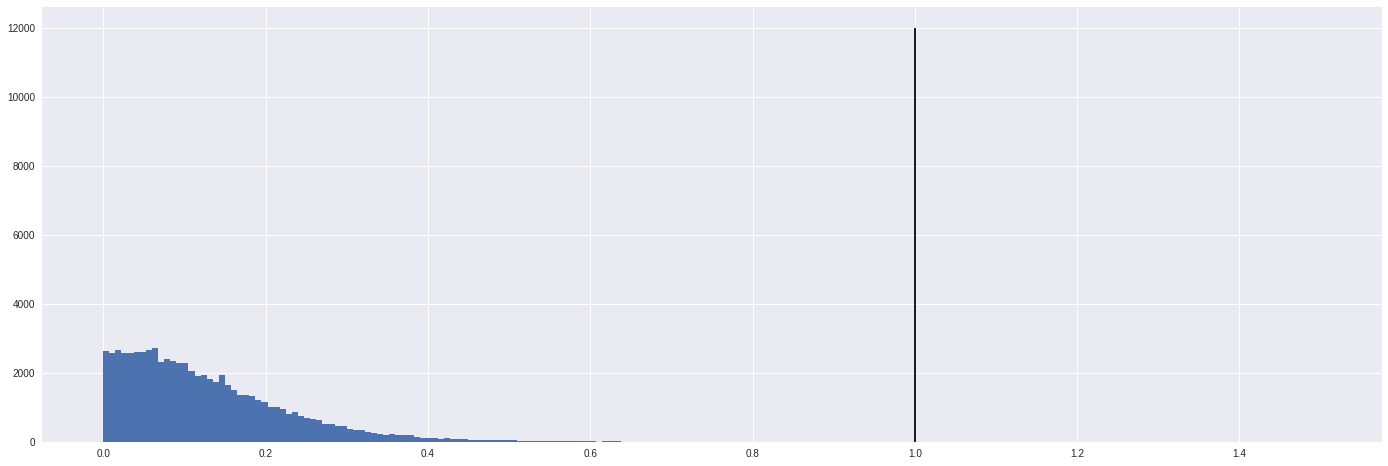

17 70000 0.000242857142857
done.


In [7]:
f('weight')

len(cv) = 422
trained


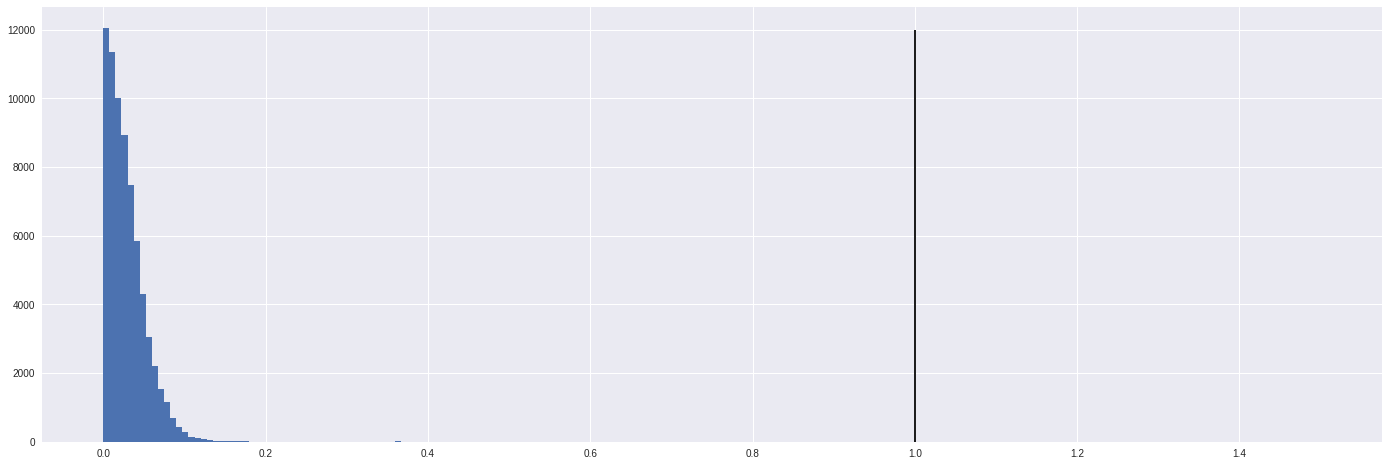

18 70000 0.000257142857143
done.


In [8]:
f('height')

In [9]:
t2 = train.drop(['id', 'cardio'], axis=1).astype('str')
t2.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,18393,2,168,62.0,110,80,1,1,0,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,1
2,18857,1,165,64.0,130,70,3,1,0,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1
4,17474,1,156,56.0,100,60,1,1,0,0,0


In [10]:
def w2ngrams(w, n):
    if len(w) < n:
        return []
    res = []
    for i in range(len(w) - n + 1):
        p = w[i:i+n]
        res.append(p)
    return res
w2ngrams('test', 3)

['tes', 'est']

In [11]:
d = {}
mm = [0, 10000]
ms = ['', '']

def ff(x):
    global ml
    x = '^' + x + '$'
    ng = [p for n in range(1,4) for p in w2ngrams(x,n)]
    if mm[0] < len(ng):
        ms[0] = x
        mm[0] = len(ng)
    if mm[1] > len(ng):
        ms[1] = x
        mm[1] = len(ng)
    for p in ng:
        d[p] = 1 if p not in d else d[p] + 1

t2.height.apply(ff)
t2.weight.apply(ff)
t2.ap_hi.apply(ff)
t2.ap_lo.apply(ff)
del d['^'], d['$']
len(d), mm[0], mm[1], ms[0], ms[1]

(717, 18, 6, '^112.0$', '^7$')

In [12]:
print(d)

{'1': 167237, '6': 72273, '8': 68014, '^1': 148236, '16': 36694, '68': 7275, '8$': 9553, '^16': 36635, '168': 4416, '68$': 4428, '5': 51439, '15': 21991, '56': 3741, '6$': 6340, '^15': 21636, '156': 2768, '56$': 2766, '65': 9835, '5$': 12077, '165': 5902, '65$': 5976, '9': 34069, '69': 5099, '9$': 6316, '169': 2796, '69$': 2895, '51': 907, '1$': 4078, '151': 628, '51$': 628, '7': 57129, '57': 2539, '7$': 5336, '157': 1818, '57$': 1823, '17': 16565, '78': 3353, '^17': 16482, '178': 1233, '78$': 1257, '58': 4669, '158': 3323, '58$': 3325, '4': 25136, '64': 5019, '4$': 6845, '164': 3407, '64$': 3415, '3': 20127, '73': 2548, '3$': 5085, '173': 1080, '73$': 1102, '18': 3000, '81': 1111, '^18': 2932, '181': 193, '81$': 214, '2': 43499, '72': 4358, '2$': 7105, '172': 2025, '72$': 2047, '0': 240312, '70': 19453, '0$': 217265, '170': 5405, '70$': 15670, '54': 2047, '154': 1453, '54$': 1452, '62': 5124, '162': 3268, '62$': 3272, '63': 4160, '163': 2523, '63$': 2529, '53': 1509, '153': 1074, '53$

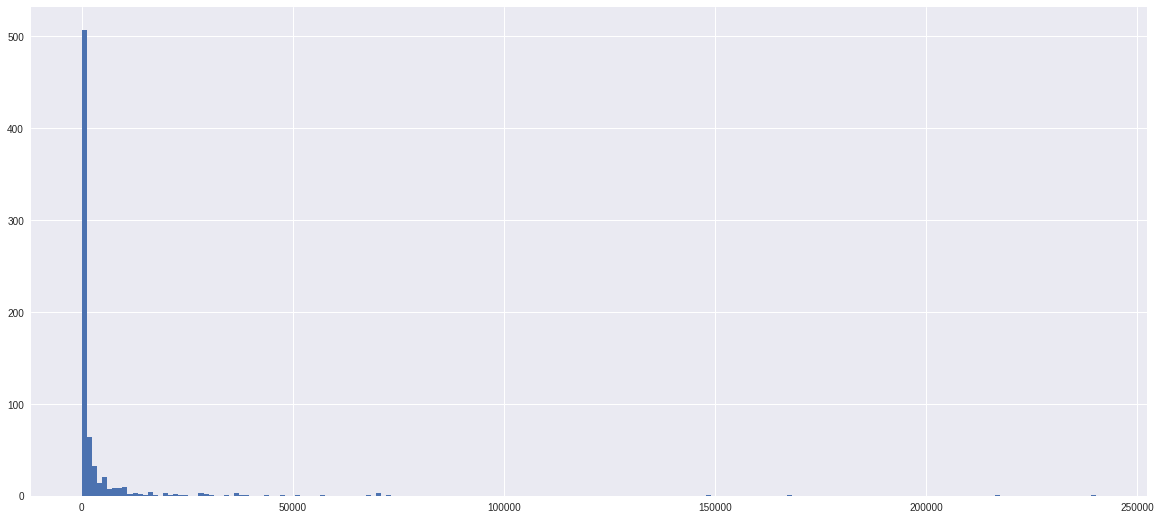

In [13]:
h = list(d.values())
plot.figure(figsize=(20, 9))
plot.hist(h, bins=200)
plot.show()

In [30]:
if 'wsum' in t2.columns:
    t2.drop(['wsum', 'wsl'], axis=1, inplace=True)
t2['wsum'] = t2.sum(axis=1).apply(lambda x:x.replace('.','').replace('-',''))
t2['wsl'] = t2['wsum'].apply(lambda x:len(x))
print(t2.wsl.describe())
t2.head()

count    70000.000000
mean        22.131929
std          0.451677
min         20.000000
25%         22.000000
50%         22.000000
75%         22.000000
max         26.000000
Name: wsl, dtype: float64


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,wsum,wsl
0,18393,2,168,62.0,110,80,1,1,0,0,1,1839321686201108011001,22
1,20228,1,156,85.0,140,90,3,1,0,0,1,2022811568501409031001,22
2,18857,1,165,64.0,130,70,3,1,0,0,0,1885711656401307031000,22
3,17623,2,169,82.0,150,100,1,1,0,0,1,17623216982015010011001,23
4,17474,1,156,56.0,100,60,1,1,0,0,0,1747411565601006011000,22


In [31]:
for i in range(26):
    train['w' + str(i)] = t2.wsum.apply(lambda x:int(x[i]) if i < len(x) else -1)
train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17,w18,w19,w20,w21,w22,w23,w24,w25
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,1,8,3,9,3,2,1,6,8,6,2,0,1,1,0,8,0,1,1,0,0,1,-1,-1,-1,-1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,2,0,2,2,8,1,1,5,6,8,5,0,1,4,0,9,0,3,1,0,0,1,-1,-1,-1,-1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,1,8,8,5,7,1,1,6,5,6,4,0,1,3,0,7,0,3,1,0,0,0,-1,-1,-1,-1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,1,7,6,2,3,2,1,6,9,8,2,0,1,5,0,1,0,0,1,1,0,0,1,-1,-1,-1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,1,7,4,7,4,1,1,5,6,5,6,0,1,0,0,6,0,1,1,0,0,0,-1,-1,-1,-1


In [32]:
xgb_params = dict(
    learning_rate = 0.02,
    #objective = 'binary:logistic',
    #eval_metric = 'logloss',
    silent = 1,
    seed = 1
    )
def f(col, mark = 1, cut_max = 1.5):
    #print(np.sum(train[col] != train[col]))
    x = np.abs(train[col].values)
    dtrain = xgb.DMatrix(train.drop(['cardio', 'id', col], axis=1).values, label=x)
    cv = xgb.cv(xgb_params, dtrain, num_boost_round=10000, early_stopping_rounds=20)
    print('len(cv) =', len(cv))
    bst = xgb.train(xgb_params, dtrain, num_boost_round=len(cv))
    print('trained')
    x2 = bst.predict(dtrain)
    e = np.abs(x - x2)
    k = np.where(np.abs(x) > 1e-5, e / x, e)
    k = np.where(k < cut_max, k, cut_max)
    plot.figure(figsize=(24, 8))
    plot.hist(k, bins=200)
    plot.vlines(x=mark, ymin=0, ymax=12000)
    plot.show()
    print(np.sum(k > mark), len(k), np.sum(k > mark) / len(k))
    print('done.')

len(cv) = 524
trained


/home/user/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in true_divide


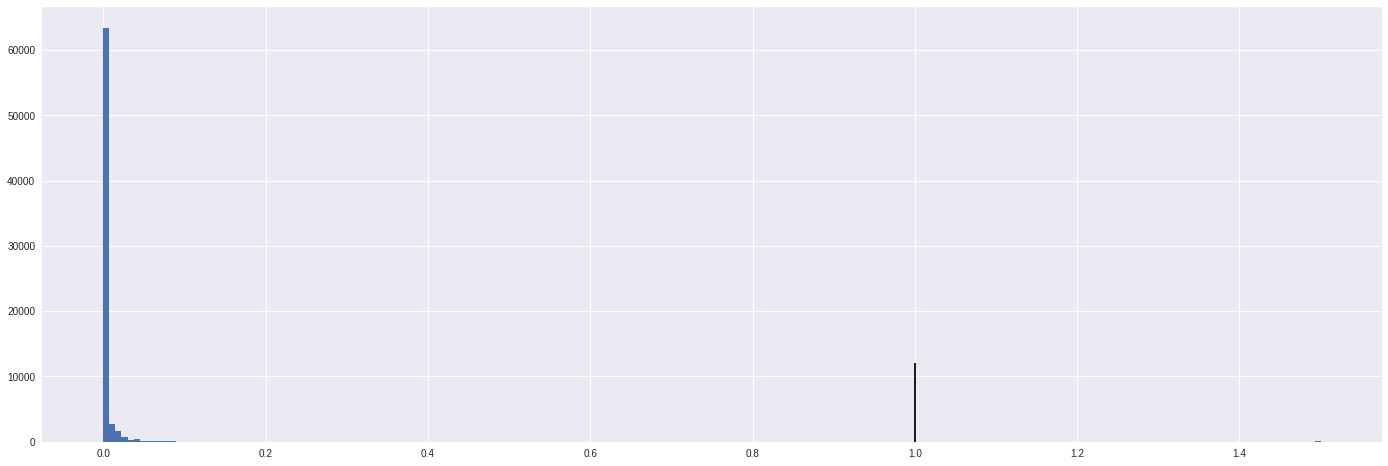

53 70000 0.000757142857143
done.


In [33]:
f('ap_lo')

len(cv) = 156
trained


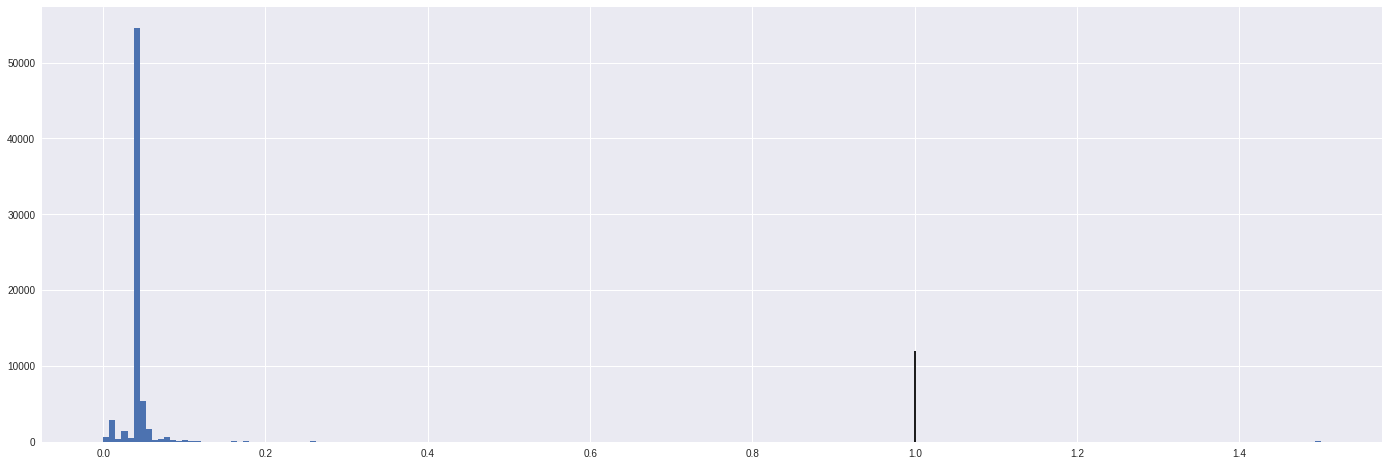

102 70000 0.00145714285714
done.


In [34]:
f('ap_hi')

len(cv) = 519
trained


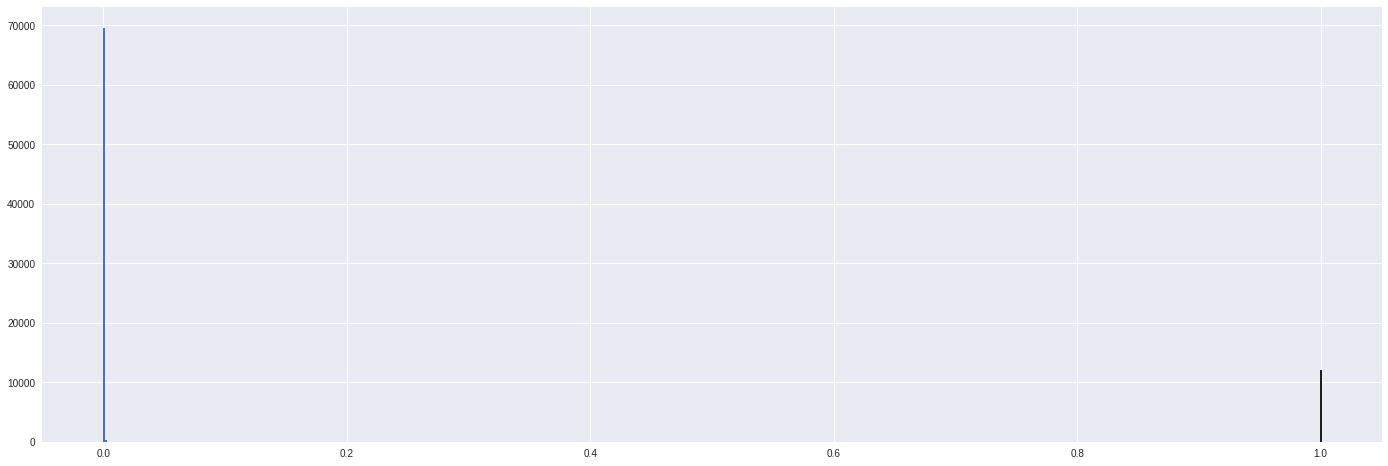

0 70000 0.0
done.


In [35]:
f('weight')

len(cv) = 412
trained


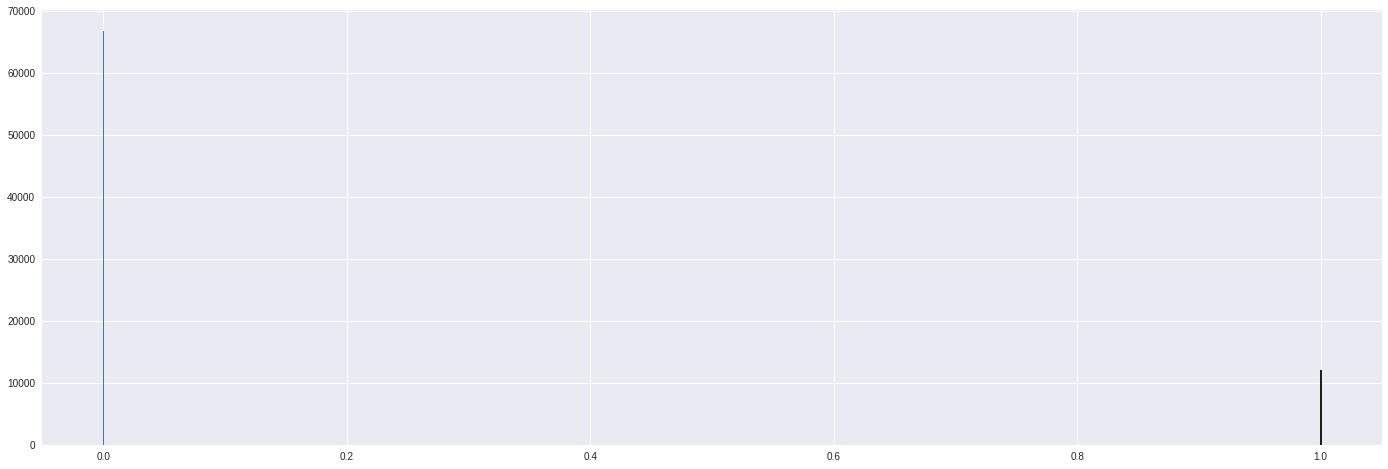

0 70000 0.0
done.


In [36]:
f('height')